# Examining Housing Affordability in the U.S.
# River Alaqidy (alaqidy@wisc.edu)

In [15]:
import pandas as pd  
import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter
%matplotlib inline 
import seaborn as sns 
import geopandas as geo
from shapely.geometry import Polygon

## Disparity Between Home Price and Income

In [16]:
# read in the median housing price data
housing_price = pd.read_csv('MSPUS.csv')
housing_price['DATE'] = pd.to_datetime(housing_price['DATE'])

# relevant time period used is between 1984-2022
housing_price = housing_price[(housing_price['DATE'] >= pd.to_datetime('1984-01-01')) & (housing_price['DATE'] <= pd.to_datetime('2022-01-01'))]

# read in data for household income that will also be relevant for the time period 1984-2022
household_income = pd.read_csv('MEHOINUSA672N.csv')
household_income['DATE'] = pd.to_datetime(household_income['DATE'])

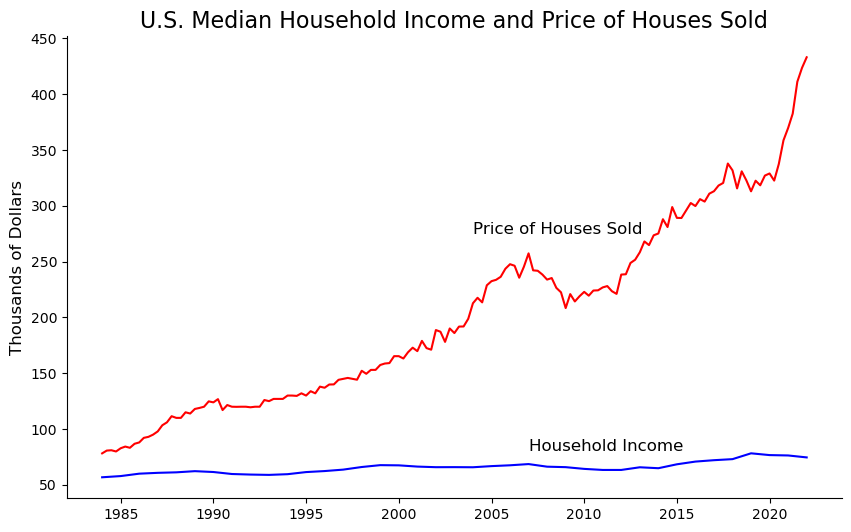

In [17]:
# plot the increase in median housing sales and household income in line plot
fig, ax = plt.subplots(figsize=(10,6)) 

# plot the lines for housing price and household income
# to make y axis easier to read the dollar values are divided by a thousand
ax.plot(housing_price['DATE'], housing_price['MSPUS']/1000, color='red')
ax.plot(household_income['DATE'], household_income['MEHOINUSA672N']/1000, color='blue')

# label both lines on graph
ax.text(pd.to_datetime('2007-01-01'), 80, 'Household Income', fontsize=12)
ax.text(pd.to_datetime('2004-01-01'), 275, 'Price of Houses Sold', fontsize=12)

# label y axis to emphasize that values are in thousands
ax.set_ylabel('Thousands of Dollars', fontsize=12)

# title for graph
ax.set_title('U.S. Median Household Income and Price of Houses Sold', fontsize=16)

# clean up graph and save figure as svg
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('income_housing.svg') 
plt.show()

## Active Housing Available in the Market

### Market Supply for 2016

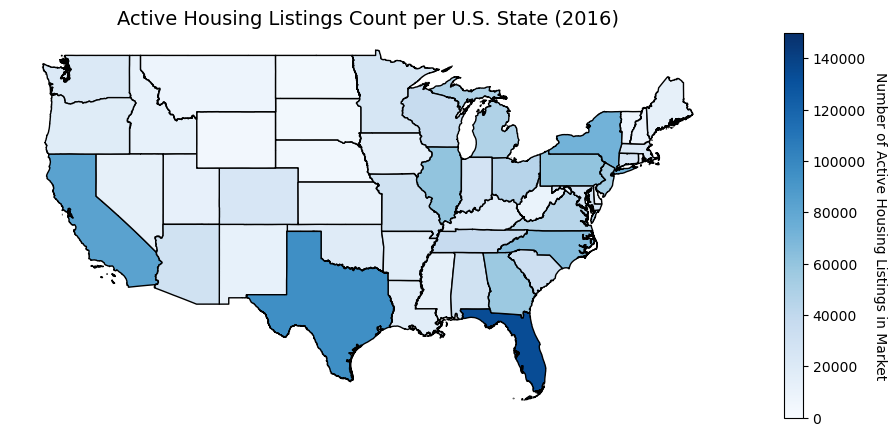

In [18]:
# create choropleth of active listings of housing in the market from 2016
# read in data containing shape of the us
us_figure = geo.read_file('cb_2018_us_state_500k.zip')

# for figure we will use only continental states
states_to_remove = ['Puerto Rico', 'American Samoa',
                    'United States Virgin Islands', 'Guam',
                    'Commonwealth of the Northern Mariana Islands','Hawaii','Alaska']
continental_states = us_figure[~us_figure['NAME'].isin(states_to_remove)]

# load in the active listing inventory for each state
states_data = pd.read_csv('RDC_Inventory_Core_Metrics_State_History.csv')
# last row is not related data
states_data = states_data.drop(states_data.index[-1])

# dataframe for 2016 now contains date, state name, abbreviation, and active listing count 
states_data = states_data[['month_date_yyyymm','state','state_id','active_listing_count']]
states_16 = states_data[states_data['month_date_yyyymm'] == '201609']

# merge the data for the shape of the us with the data for active listing count
listings_16 = pd.merge(left=continental_states, right=states_16,left_on='NAME',right_on='state',how='left')

# plot choropleth of active listing count per state
fig, gax = plt.subplots(figsize=(15,5))

# color on plot will represent active listings, darker blue = more listings, lighter = less
listings_16.plot(ax = gax, column='active_listing_count', edgecolor='black', cmap = 'Blues', legend=True, vmin=0, vmax=150000)

# add title
plt.title('Active Housing Listings Count per U.S. State (2016)', fontsize=14)

# label cbar
cbar = gax.get_figure().get_axes()[1]  # Assuming colorbar is the second axis of the figure
cbar.set_ylabel('Number of Active Housing Listings in Market', rotation=270, labelpad=15)

# remove axis from plot
plt.axis('off')
plt.savefig('2016_active_listing.svg')
plt.show()

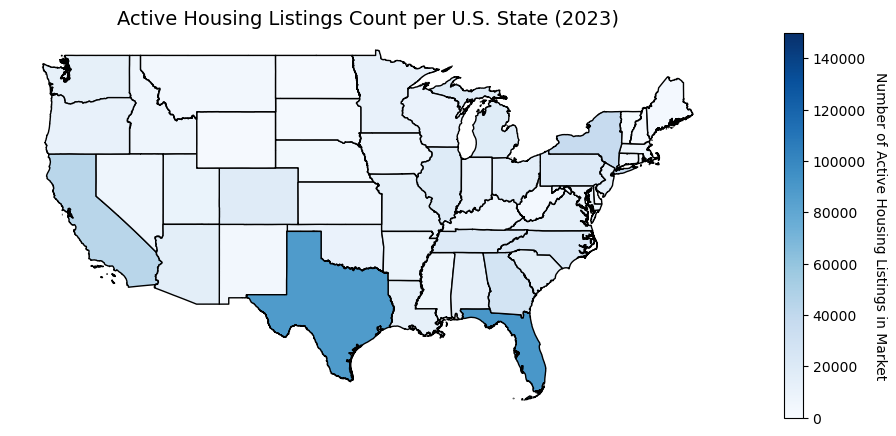

In [19]:
# dataframe for 2023 now contains values
states_23 = states_data[states_data['month_date_yyyymm'] == '202309']
# us shape and active listings now in same dataframe
listings_23 = pd.merge(left=continental_states, right=states_23,left_on='NAME',right_on='state',how='left')

# plot choropleth of active listing count per state
fig, gax = plt.subplots(figsize=(15,5))

# color on plot will represent active listings, darker blue = more listings, lighter = less
listings_23.plot(ax = gax, column='active_listing_count', edgecolor='black', cmap = 'Blues', legend=True, vmin=0, vmax=150000)

# add title
plt.title('Active Housing Listings Count per U.S. State (2023)', fontsize=14)

# label cbar
cbar = gax.get_figure().get_axes()[1]  # Assuming colorbar is the second axis of the figure
cbar.set_ylabel('Number of Active Housing Listings in Market', rotation=270, labelpad=15)

# remove axis from plot
plt.axis('off')
plt.savefig('2023_active_listing.svg')
plt.show()

## The Effect of Housing Supply on Market Pricing

In [20]:
# load in median price of houses sold in US
housing_price_active = pd.read_csv('MSPUS.csv')

# load in the active housing inventory of the entire US as a whole
active_housing = pd.read_csv('ACTLISCOUUS.csv')
# set index to datetime object
active_housing['DATE'] = pd.to_datetime(active_housing['DATE'])
active_housing.set_index('DATE',inplace=True)

# for simplicity will deal with quarterly data instead of monthly
active_housing = active_housing.resample('q').mean()
# align dates to start at beginning of month
active_housing.index = active_housing.index + pd.offsets.MonthBegin(1)

# to match housing price data will look at housing inventory before or on 2023-07-01
active_housing = active_housing[active_housing.index <= '2023-07-01']

In [21]:
# to match with active listing data pricing data will start from 2016-07-01
housing_price_active = housing_price_active[housing_price_active['DATE'] >= '2016-07-01']

# set index of pricing data to be datetime object
housing_price_active['DATE'] = pd.to_datetime(housing_price_active['DATE'])
housing_price_active.set_index('DATE',inplace=True)

# merge listings count and housing price to make regression plot
listings_price = pd.merge(left=active_housing, right=housing_price_active, left_on='DATE', right_on='DATE', how='inner')

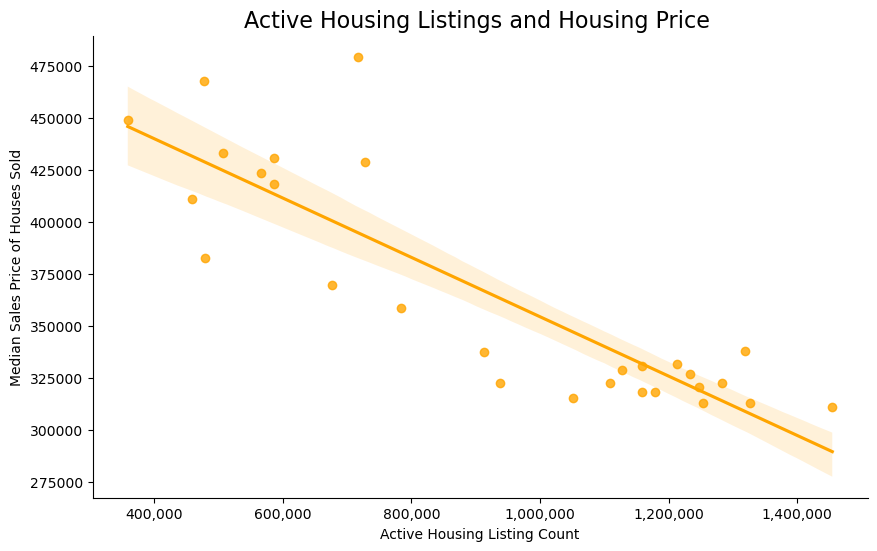

In [22]:
# create regression of impact of housing count on housing pricing
fig, ax = plt.subplots(figsize=(10,6)) 

# independent variable is active listings, dependent is housing price
sns.regplot(x='ACTLISCOUUS', y='MSPUS', data=listings_price,       
            ax = ax,                                              
            color = 'orange',                                  
            ci = 90)             # 90% confidence interval                                         

# clean up plot and give title and axis labels
sns.despine(ax = ax) 
plt.xlabel('Active Housing Listing Count')
plt.ylabel('Median Sales Price of Houses Sold')
ax.set_title('Active Housing Listings and Housing Price ', fontsize=16)

# Set the x-axis formatter to display tick labels as regular numbers
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
plt.savefig('reg_activel_hp.svg')
plt.show()

## Inflation of Housing Construction Materials

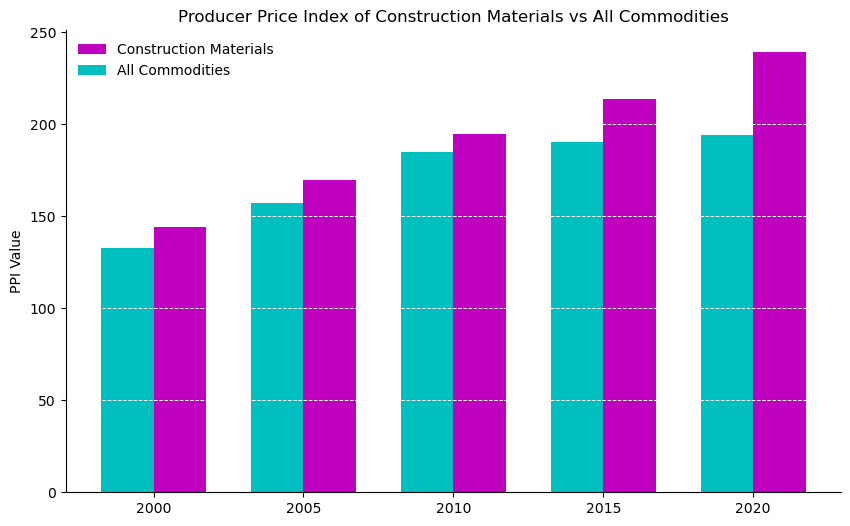

In [23]:
# load in data of the cost of constructing houses based on produce price index of construction commodities
construction_cost = pd.read_csv('WPUSI012011.csv')

# set index of construction cost data to datetime object
construction_cost['DATE'] = pd.to_datetime(construction_cost['DATE'])
construction_cost.set_index('DATE',inplace=True)

# make data represented in yearly format for bar graph
construction_cost_y = construction_cost.resample('y').mean()
# will plot the changes for every 5 years starting from the year 2000
construction_cost_y.index = construction_cost_y.index.year.astype(str)
construction_cost_y = construction_cost_y[construction_cost_y.index.astype(int) % 5 == 0]
construction_cost_y = construction_cost_y[construction_cost_y.index.astype(int) >= 2000]

# load the producer price index of all commodities to compare to construction cost
ppi_all = pd.read_csv('PPIACO.csv')

# make index datetime object
ppi_all['DATE'] = pd.to_datetime(ppi_all['DATE'])
ppi_all.set_index('DATE',inplace=True)

# make data in yearly format
ppi_all_y = ppi_all.resample('y').mean()
# will plot the changes for every 5 years starting from 200
ppi_all_y.index = ppi_all_y.index.year.astype(str)
ppi_all_y = ppi_all_y[ppi_all_y.index.astype(int) % 5 == 0]
ppi_all_y = ppi_all_y[ppi_all_y.index.astype(int) >= 2000]

# plot ppi of construction materials and all commodities
plt.figure(figsize=(10, 6))

# bar proportions of side-by-side graph
bar_width = 0.35
indices = range(len(construction_cost_y.index))

# plot all commodities to left, and construction materials to right
plt.bar([i + bar_width for i in indices], construction_cost_y['WPUSI012011'], width=bar_width, label='Construction Materials', color='m')
plt.bar(indices, ppi_all_y['PPIACO'], width=bar_width, label='All Commodities', color='c')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Mean Value')
plt.title('Producer Price Index of Construction Materials vs All Commodities')
plt.xticks([i + bar_width/2 for i in indices], construction_cost_y.index)

# format legend
legend = plt.legend()
legend.get_frame().set_edgecolor('white')

# add white grid to y-axis
plt.grid(axis='y', color='white', linestyle='--', linewidth=0.7)

# clean up graph, add labels, and save image as svg
plt.xlabel('')
plt.ylabel('PPI Value')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('ppi_cmp.svg') 
# Show the plot
plt.show()

## Impact of Construction Cost on Housing Market Supply and Pricing

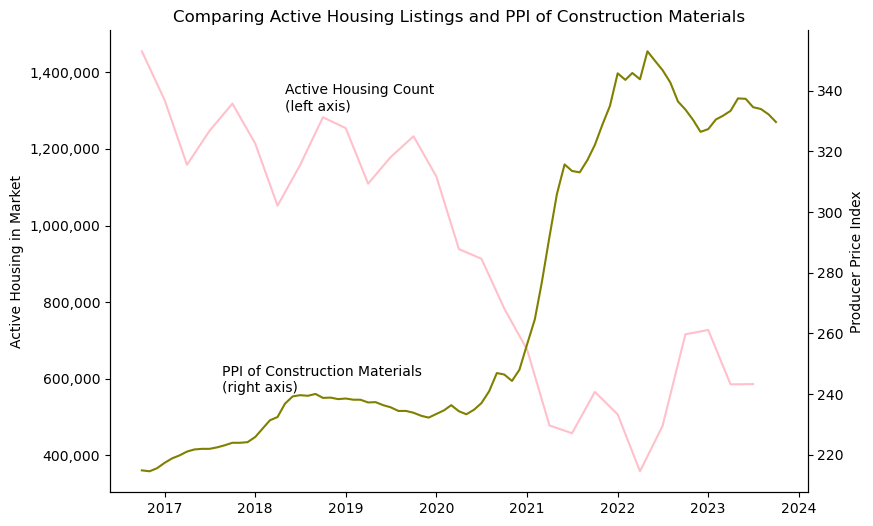

In [24]:
# twin graph with ppi of construction materials and supply of houses
# filter construction_cost data starting from October 2016
construction_cost_plot = construction_cost[construction_cost.index >= '2016-10-01']

# plot with twin y-axis
fig, ax = plt.subplots(figsize=(9,6))

# plot active housing in the market on the left y-axis
line1 = ax.plot(active_housing.index, active_housing['ACTLISCOUUS'], color='pink', label='Active Housing Listings')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
ax.set_ylabel('Active Housing in Market')
ax.set_title('Comparing Active Housing Listings and PPI of Construction Materials')

# plot PPI of construction materials on the right y-axis
ax2 = ax.twinx()
ax.spines['top'].set_visible(False)   # get rid of the line on top
ax2.spines['top'].set_visible(False)   # get rid of the line on top
line2 = ax2.plot(construction_cost_plot.index, construction_cost_plot['WPUSI012011'], color='olive', label='PPI of Construction Materials')
ax2.set_ylabel('Producer Price Index')

# add labels for each line on the left side, inside the graph
label1_coords = (0.25, 0.82)  # coordinates of labels
label2_coords = (0.16, 0.21)  # coordinates of labels

# label line plot and clean up graph
ax.text(label1_coords[0], label1_coords[1], 'Active Housing Count\n(left axis)', color='black', transform=ax.transAxes, verticalalignment='bottom', horizontalalignment='left')
ax.text(label2_coords[0], label2_coords[1], 'PPI of Construction Materials\n(right axis)', color='black', transform=ax.transAxes, verticalalignment='bottom', horizontalalignment='left')
plt.savefig('housingCount_constMaterials.svg')
plt.show()

In [25]:
# regression data between ppi's affect on housing price
ppi_construct = pd.merge(left=construction_cost, right=active_housing, left_on='DATE', right_on='DATE', how='inner')

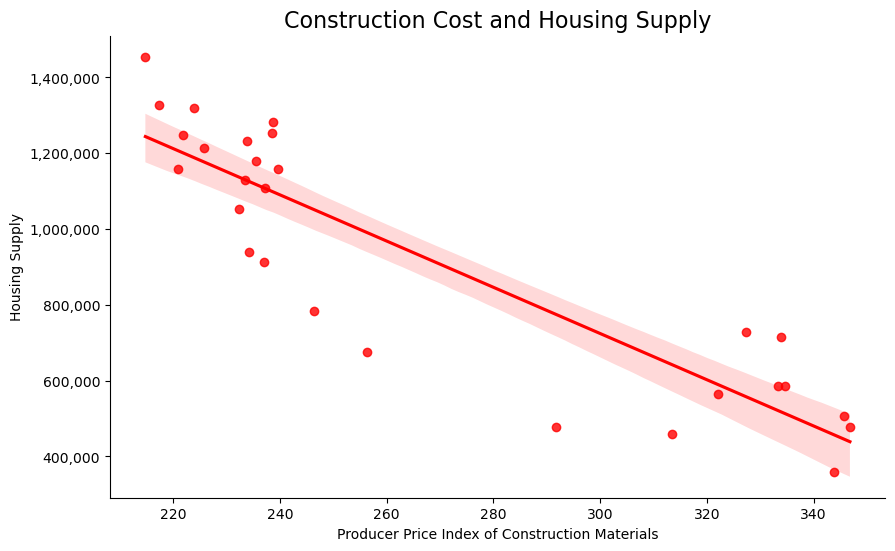

In [26]:
# regression plot of ppi affect on housing supply
fig, ax = plt.subplots(figsize=(10,6)) 

# independent variable is ppi of construction materials and dependent is housing supply
sns.regplot(x='WPUSI012011', y='ACTLISCOUUS', data=ppi_construct,              
            ax = ax,                                             
            color = 'red',                                      
            ci = 90)                # 90% confidence interval                            

# clean up and label graph
sns.despine(ax = ax) 
ax.set_title('Construction Cost and Housing Supply', fontsize=16)
# makes actual values appear on graph y axis
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
# label graph axis
ax.set_ylabel('Housing Supply')
ax.set_xlabel('Producer Price Index of Construction Materials')
plt.savefig('reg_constCost_hs.svg')
plt.show()

In [27]:
# update housing price to be usable for regression plot
housing_price.set_index('DATE', inplace=True)
# ppi of construction cost and data of housing prices
ppi_hp_reg = pd.merge(left=construction_cost, right=housing_price, left_on='DATE', right_on='DATE', how='inner')

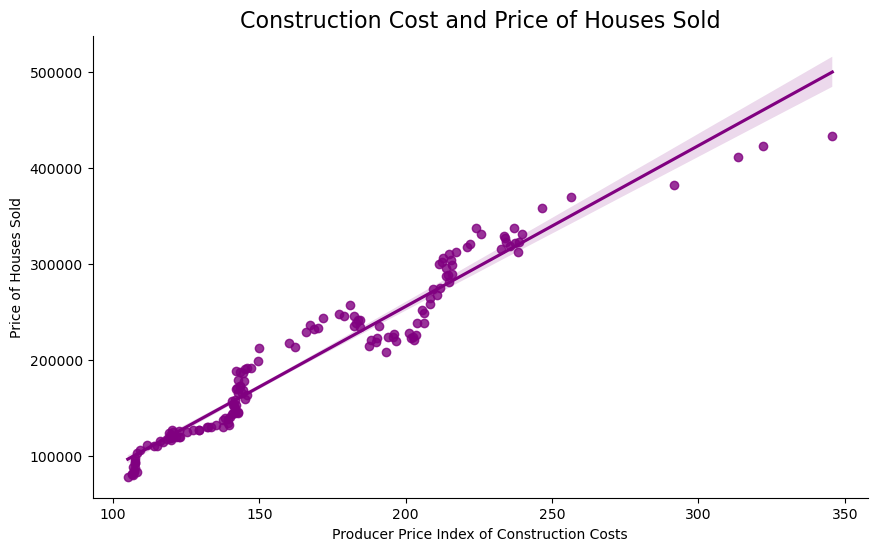

In [28]:
# regression impact of ppi construction materials on housing price
fig, ax = plt.subplots(figsize=(10,6)) 

# independent variable is construction cost, dependent is hosuing price
sns.regplot(x='WPUSI012011', y='MSPUS', data=ppi_hp_reg,          
            ax = ax,                                            
            color = 'purple',                                  
            ci = 90)               # 90% confidence interval                                

# clean up graph and give title
sns.despine(ax = ax) 
ax.set_title('Construction Cost and Price of Houses Sold', fontsize=16)
# set axis labels
ax.set_ylabel('Price of Houses Sold')
ax.set_xlabel('Producer Price Index of Construction Costs')
plt.savefig('reg_constCost_hp.svg')
plt.show()